# Understanding Invertible Logic Gates

p-Bits can be understood as a Bernoulli variable parameterized by an input probability $p$ - ie. when a p-bit is measured a proportion $p$ of the time it will be $1$ and $1-p$ of the time it will be a $0$. And like ordinary and q-bits, they can be made to work with each other to build computational logics.

"Invertible" logic or "Probabilistic Spin Logic", like probabilistic/stochastic computing, has a nearby cousin which it can also be confused with called reversible (or as I would prefer bijective) computing, where its possible run a computation backwards. This isn't invertible logic, despite its name, where all possible values terminals into a logic gate have a probability and we use the most likely answer to determine what that is.

The way we do this is that we can connect multiple p-bits together to form small Boltzmann machines. Boltzmann machines can be thought of as neural nets which recursively propagate a stochastic signal through itself. The Boltzmann machine then has an energy defined as: 

$$
\begin{equation*} H = - \sum _{i} h_{i} m_{i} - \sum _{i < j} J_{ij} m_{i} m_{j}. \tag{1}\end{equation*}
$$

Where $m_i$ is the output of the $i^{\text{th}}$ p-bit and $J_{ij}$ is the weight between and $h_i$ is a bias term. To determine the gates we fix an energy profile of the behaviour that we would like to see, and then we use linear programming to find the $J_{ij}$ and $h_{i}$ that create this energy profile given a certain input.

For example, if we were trying to define a Boltzmann AND-gate (in p-computing this is called the invertible AND), we'd define the following energy profile:

A | B | C = AND(A,B)| Valid? | H (Energy) |
--|---|---|--------|---|
-1 | -1 | -1 |Yes|$E_0 = E_{min}$|
-1 | +1 | -1 |Yes|$E_1 = E_{min}$|
+1 | -1 | -1 |Yes|$E_2 = E_{min}$|
+1 | +1 | -1 |No|$E_3 \geq E_{min} + d$|
-1 | -1 | +1 |No|$E_4 \geq E_{min} + d$|
-1 | +1 | +1 |No|$E_5 \geq E_{min} + d$|
+1 | -1 | +1 |No|$E_6 \geq E_{min} + d$|
+1 | +1 | +1 |Yes|$E_7 = E_{min}$|

And for each combination of values of our logic gate terminals, we describe the energy that we would like to see from our Boltzmann machine and then we use Linear Programming to find the weights and biases necessary to create this energy profile.

In [4]:
import pulp

problem = pulp.LpProblem('AND',pulp.LpMinimize)

# Energy
E = pulp.LpVariable('E',-10,10,'Continuous')
# Biases
h = pulp.LpVariable.dicts('h',([0],[0,1,2]),-5,5,'Integer')
# Weights
j = pulp.LpVariable.dicts('j',([0],[0,1,2]),-5,5,'Integer')

# Dummy summation variables
H_h, H_j = (0,0)

# Iterate over rows of the above table
for i in range(8):
    # Generate correct values
    A = 2 * int(i % 4 >= 2) - 1
    B = 2 * (i % 2) - 1
    C = 2 * int(i >= 4) - 1

    # Individual terms of final energy
    H_hp = A*h[0][0] + B*h[0][1] + C*h[0][2]
    H_jp = A*B*j[0][0] + B*C*j[0][1] + A*C*j[0][2]

    # Summed terms of final energy
    H_h = H_h + H_hp
    H_j = H_j + H_jp

    # Add energy constraints determined above
    if ((A > 0) or (B > 0)) == (C > 0):
        problem += (-1)*H_hp-H_jp-E == 0
    else:
        problem += (-1)*H_hp-H_jp-E-1 >= 0

# Finally layout the objective function to minimize
problem += -H_h-H_j-E

# Check that problem described is what was intended
problem.coefficients

<bound method LpProblem.coefficients of AND:
MINIMIZE
-1*E + 0*h_0_0 + 0*h_0_1 + 0*h_0_2 + 0*j_0_0 + 0*j_0_1 + 0*j_0_2 + 0
SUBJECT TO
_C1: - E + h_0_0 + h_0_1 + h_0_2 - j_0_0 - j_0_1 - j_0_2 = 0

_C2: - E + h_0_0 - h_0_1 + h_0_2 + j_0_0 + j_0_1 - j_0_2 >= 1

_C3: - E - h_0_0 + h_0_1 + h_0_2 + j_0_0 - j_0_1 + j_0_2 >= 1

_C4: - E - h_0_0 - h_0_1 + h_0_2 - j_0_0 + j_0_1 + j_0_2 >= 1

_C5: - E + h_0_0 + h_0_1 - h_0_2 - j_0_0 + j_0_1 + j_0_2 >= 1

_C6: - E + h_0_0 - h_0_1 - h_0_2 + j_0_0 - j_0_1 + j_0_2 = 0

_C7: - E - h_0_0 + h_0_1 - h_0_2 + j_0_0 + j_0_1 - j_0_2 = 0

_C8: - E - h_0_0 - h_0_1 - h_0_2 - j_0_0 - j_0_1 - j_0_2 = 0

VARIABLES
-10 <= E <= 10 Continuous
-5 <= h_0_0 <= 5 Integer
-5 <= h_0_1 <= 5 Integer
-5 <= h_0_2 <= 5 Integer
-5 <= j_0_0 <= 5 Integer
-5 <= j_0_1 <= 5 Integer
-5 <= j_0_2 <= 5 Integer
>

In [5]:
# Solve problem in question
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/thomas/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/c5dbd5653a954a74a0035c786130569e-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/c5dbd5653a954a74a0035c786130569e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 89 RHS
At line 98 BOUNDS
At line 113 ENDATA
Problem MODEL has 8 rows, 7 columns and 56 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.75 - 0.00 seconds
Cgl0004I processed model has 8 rows, 7 columns (6 integer (0 of which binary)) and 56 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 3 found by DiveCoefficient after 3 iterations and 0 nodes (0.00 seconds)
Cbc0031I 3 added rows had average density of 7
Cbc0013I At root node, 3 cuts changed objective from 0.75 to 2.99999

1

In [6]:
# Get final values of output
print("J_AB=",pulp.value(j[0][0]))
print("J_BC=",pulp.value(j[0][1]))
print("J_AC=",pulp.value(j[0][2]))
print("- "*5)
print("h_A=",pulp.value(h[0][0]))
print("h_B=",pulp.value(h[0][1]))
print("h_C=",pulp.value(h[0][2]))

J_AB= -1.0
J_BC= 2.0
J_AC= 2.0
- - - - - 
h_A= -1.0
h_B= -1.0
h_C= 2.0


This gives us the weights and biases that we desire, and gives us the final Hamiltonian that we seek:

$$
J_{AND} = 
\begin{bmatrix}
J_{AA} & J_{AB} & J_{AC} \\
J_{BA} & J_{BB} & J_{BC} \\
J_{CA} & J_{CB} & J_{CC} 
\end{bmatrix} =
\begin{bmatrix}
0 & -1 & +2 \\
-1 & 0 & +2 \\
+2 & +2 & 0 
\end{bmatrix}
\qquad
h = \begin{bmatrix}
+1 & +1 & -2
\end{bmatrix}
$$

This acts as our update rule across the Boltzmann Machine, and with it we can do a preliminary simulation of p-bit computation and see exactly why what we've found is actually an "invertible" logic gate.

In [4]:
import numpy as np
from objects import pbit

# Here we first describe the general p-bit network
class pbit_network:
    def __init__(self, pbits: list, J: np.array, h: np.array):

        self.pbits = pbits
        self.J = J
        self.h = h

    def step(self, dt = 1):

        sample = [p.sample() for p in self.pbits]
        forward = (self.J * dt) @ np.array(sample).T + self.h * dt

        for idx, p in enumerate(self.pbits):
            p.activation = forward[idx]

    def sample(self):
        return [p.sample() for p in self.pbits]


class AND(pbit_network):

    def __init__(self):

        # Note in this format we take the first two pbits to be inputs A,B
        # and the final pbit to be the output C = AND(A,B)
        J = np.array([[0, -1, 2], [-1, 0, 2], [2, 2, 0]])
        h = np.array([1, 1, -2])
        super().__init__([pbit(), pbit(), pbit()], J, h)

We'll now run two experiments to see exactly what we mean by an invertible logic gate:

##### Experiment 1 - Ordinary Logic Gate

We should expect that if we clamp A and B to different values that we get the correct result, ie. C = AND(A,B).

##### Experiment 2 - Invertibility

Our logic gate is invertible, that means that if we clamp C to some output - statistically, A and B will converge to values such that AND(A,B) will be the C we clamped.

In [6]:
# Experiment 1

print("- - - EXPERIMENT 1 - - -\n")

num_steps = 10
num_samples = 100

# Iterate over possible inputs
for i in range(4):

    and_gate = AND()

    A = 2 * (i % 2) - 1
    B = 2 * (i // 2) - 1

    and_gate.pbits[0].clamped = A
    and_gate.pbits[1].clamped = B

    # Let it converge
    for i in range(num_steps):
        and_gate.step()

    # Take some samples
    samples = []
    for i in range(num_samples):
        samples.append(and_gate.sample())

    count = sum([s[2] > 0 for s in samples])

    print(f"{(A+1)//2} AND {(B+1)//2} = {count/num_samples}")

- - - EXPERIMENT 1 - - -

0 AND 0 = 0.0
1 AND 0 = 0.02
0 AND 1 = 0.0
1 AND 1 = 0.99


In [7]:
# Experiment 2

num_steps = 10
num_samples = 100

print("- - - EXPERIMENT 2 - - -\n")

# Iterate over possible inputs
for i in range(2):

    and_gate = AND()

    C = 2 * i - 1

    and_gate.pbits[2].clamped = C

    # Let it converge
    for i in range(num_steps):
        and_gate.step()

    # Take some samples
    samples = []
    for i in range(num_samples):
        samples.append(and_gate.sample())

    countA = sum([(s[0] > 0) & (s[1] > 0)for s in samples])

    print(f"C={(C+1)//2} implies AND(A,B)={countA/num_samples}")

- - - EXPERIMENT 2 - - -

C=0 implies AND(A,B)=0.04
C=1 implies AND(A,B)=0.97


So we can clearly see the reversibility in action. We'll conduct one final experiment to precisely explain the exact nature of this invertibility:

##### Experiment 3 - Inversion Distribution

If AND(A,B) = 0, there are 3 possible combinations

In [20]:
num_steps = 10
num_samples = 100

and_gate = AND()

C = -1

and_gate.pbits[2].clamped = C

# Let it converge
for i in range(num_steps):
    and_gate.step()

# Take some samples
samples = []
for i in range(num_samples):
    samples.append(and_gate.sample())

count00 = sum([(s[0] < 0) & (s[1] < 0)for s in samples])
count01 = sum([(s[0] < 0) & (s[1] > 0)for s in samples])
count10 = sum([(s[0] > 0) & (s[1] < 0)for s in samples])
count11 = sum([(s[0] > 0) & (s[1] > 0)for s in samples])

print(f"C={(C+1)//2} implies\n\nP(0&0)={count00/num_samples}\nP(0&1)={count01/num_samples}\nP(1&0)={count10/num_samples}\nP(1&1)={count11/num_samples}")

C=0 implies

P(0&0)=0.44
P(0&1)=0.55
P(1&0)=0.01
P(1&1)=0.0


Depending on the random seed, the network has a tendency to converge to different distributions of "the most likely answer". This appears to be fairly random in how it converges - let's see if an average begins to emerge:

##### Experiment 4 - Inversion Statistics

We explore the final statistics more closely.

In [21]:
from numpy import mean, std

p00 = []
p01 = []
p10 = []
p11 = []

num_steps = 1000
num_samples = 100

for i in range(1000):
    and_gate = AND()

    C = -1

    and_gate.pbits[2].clamped = C

    # Let it converge
    for i in range(num_steps):
        and_gate.step(dt=1)

    # Take some samples
    samples = []
    for i in range(num_samples):
        samples.append(and_gate.sample())

    p01.append(sum([(s[0] < 0) & (s[1] > 0)for s in samples])/num_samples)
    p10.append(sum([(s[0] > 0) & (s[1] < 0)for s in samples])/num_samples)
    p00.append(sum([(s[0] < 0) & (s[1] < 0)for s in samples])/num_samples)
    p11.append(sum([(s[0] > 0) & (s[1] > 0)for s in samples])/num_samples)

print(f"C={(C+1)//2} implies\n\nP(0&0) mean:{mean(p00)}, std:{std(p00)}")
print(f"P(0&1) mean:{mean(p01)}, std:{std(p01)}")
print(f"P(1&0) mean:{mean(p10)}, std:{std(p10)}")
print(f"P(1&1) mean:{mean(p11)}, std:{std(p11)}")

C=0 implies

P(0&0) mean:0.44310000000000005, std:0.2209624176189245
P(0&1) mean:0.22016, std:0.18498425446507605
P(1&0) mean:0.23082999999999998, std:0.1865728037523154
P(1&1) mean:0.10590999999999999, std:0.12140828596104962


Now that we've tried our hands at implementing a simple `AND` gate, we can begin pushing this method for more complicated circuits, such as a bit counter. More complicated circuits require 3 kinds of nodes:

1. Input nodes
2. Output nodes
3. Auxiliary nodes

Auxiliary nodes are necessary to because the number of states required to encode all of the behavior are often larger that the $(i+o)^2$ weights that can be encoded between input and output p-bits.

Let's implement an 8-bit counter (ie. 8 inputs, 3 outputs) return in binary the number of inputs that are on, for which we don't actually need any auxiliary bits.

In [1]:
import pulp

problem = pulp.LpProblem('8-bit counter',pulp.LpMinimize)

input_bits = 2**3
output_bits = 3
io_bits = input_bits + output_bits

# Energy
E = pulp.LpVariable('E',-1e12,1e12,'Continuous')
# Biases
h = pulp.LpVariable.dicts('h',([0],[i for i in range(io_bits)]),-1e2,1e2,'Integer')
# Weights
j = pulp.LpVariable.dicts('j',([0],[i for i in range((io_bits * (io_bits - 1 )) // 2)]),-1e2,1e2,'Integer')

# Dummy summation variables
H_h, H_j = (0,0)

# Iterate over possible states
for i in range(2**io_bits):
    # Generate correct values
    vals = [2 * int(bit) - 1 for bit in format(i, f'0{io_bits}b')]
    # Individual terms of final energy
    H_hp = sum([vals[a]*h[0][a] for a in range(io_bits)])
    factors = [vals[a] * vals[b] for a in range(len(vals)-1) for b in range(a+1, len(vals))]
    H_jp = sum(factors[a]*j[0][a] for a in range((io_bits * (io_bits - 1)) // 2))

    # Summed terms of final energy
    H_h = H_h + H_hp
    H_j = H_j + H_jp

    # Add energy constraints when the number of counts is correct
    if sum([v > 0 for v in vals[:input_bits]] ) == sum([(v > 0) * 2 ** idx for idx,v in enumerate(vals[input_bits:])]):
        problem += (-1)*H_hp-H_jp-E == 0 
    else:
        problem += (-1)*H_hp-H_jp-E-1 >= 0

# Finally layout the objective function to minimize
problem += -H_h-H_j-E

# Check that problem described is what was intended
problem.coefficients

/home/thomas/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


<bound method LpProblem.coefficients of 8-bit_counter:
MINIMIZE
-1*E + 0*h_0_0 + 0*h_0_1 + 0*h_0_10 + 0*h_0_2 + 0*h_0_3 + 0*h_0_4 + 0*h_0_5 + 0*h_0_6 + 0*h_0_7 + 0*h_0_8 + 0*h_0_9 + 0*j_0_0 + 0*j_0_1 + 0*j_0_10 + 0*j_0_11 + 0*j_0_12 + 0*j_0_13 + 0*j_0_14 + 0*j_0_15 + 0*j_0_16 + 0*j_0_17 + 0*j_0_18 + 0*j_0_19 + 0*j_0_2 + 0*j_0_20 + 0*j_0_21 + 0*j_0_22 + 0*j_0_23 + 0*j_0_24 + 0*j_0_25 + 0*j_0_26 + 0*j_0_27 + 0*j_0_28 + 0*j_0_29 + 0*j_0_3 + 0*j_0_30 + 0*j_0_31 + 0*j_0_32 + 0*j_0_33 + 0*j_0_34 + 0*j_0_35 + 0*j_0_36 + 0*j_0_37 + 0*j_0_38 + 0*j_0_39 + 0*j_0_4 + 0*j_0_40 + 0*j_0_41 + 0*j_0_42 + 0*j_0_43 + 0*j_0_44 + 0*j_0_45 + 0*j_0_46 + 0*j_0_47 + 0*j_0_48 + 0*j_0_49 + 0*j_0_5 + 0*j_0_50 + 0*j_0_51 + 0*j_0_52 + 0*j_0_53 + 0*j_0_54 + 0*j_0_6 + 0*j_0_7 + 0*j_0_8 + 0*j_0_9 + 0
SUBJECT TO
_C1: - E + h_0_0 + h_0_1 + h_0_10 + h_0_2 + h_0_3 + h_0_4 + h_0_5 + h_0_6
 + h_0_7 + h_0_8 + h_0_9 - j_0_0 - j_0_1 - j_0_10 - j_0_11 - j_0_12 - j_0_13
 - j_0_14 - j_0_15 - j_0_16 - j_0_17 - j_0_18 - j_0_19 - j_

In [2]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/thomas/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3e2f8a827a6f43ae94be2d120a6d3604-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/3e2f8a827a6f43ae94be2d120a6d3604-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2053 COLUMNS
At line 139469 RHS
At line 141518 BOUNDS
At line 141653 ENDATA
Problem MODEL has 2048 rows, 67 columns and 137216 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.5 - 0.46 seconds
Cgl0003I 0 fixed, 4 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 2048 rows, 67 columns (66 integer (0 of which binary)) and 137216 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0031I 8 added rows had average density of 57.75
Cbc0013I At root node, 8 cuts changed objective from 7.5 to 13

1

In [3]:
import numpy as np

j_list = []
for a in range(io_bits * (io_bits - 1) // 2):
    j_list.append(pulp.value(j[0][a]))

h_list = []
for b in range(io_bits):
    h_list.append(pulp.value(h[0][b]))

j_matrix = np.zeros((io_bits,io_bits))
for a in range(io_bits-1):
    for b in range(a+1,io_bits):
        j_matrix[a,b] = j_list.pop(0)

j_matrix = j_matrix + j_matrix.T

h_matrix = np.zeros((1,io_bits))
for a in range(io_bits):
    h_matrix[0,a] = h_list.pop(0)

print(f"j_matrix:\n{j_matrix}")
print(f"h_matrix:\n{h_matrix}")

j_matrix:
[[ 0. -1. -1. -1. -1. -1. -1. -1.  1.  2.  4.]
 [-1.  0. -1. -1. -1. -1. -1. -1.  1.  2.  4.]
 [-1. -1.  0. -1. -1. -1. -1. -1.  1.  2.  4.]
 [-1. -1. -1.  0. -1. -1. -1. -1.  1.  2.  4.]
 [-1. -1. -1. -1.  0. -1. -1. -1.  1.  2.  4.]
 [-1. -1. -1. -1. -1.  0. -1. -1.  1.  2.  4.]
 [-1. -1. -1. -1. -1. -1.  0. -1.  1.  2.  4.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  1.  2.  4.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  0. -2. -4.]
 [ 2.  2.  2.  2.  2.  2.  2.  2. -2.  0. -8.]
 [ 4.  4.  4.  4.  4.  4.  4.  4. -4. -8.  0.]]
h_matrix:
[[-1. -1. -1. -1. -1. -1. -1. -1.  1.  2.  4.]]


This is a pretty pattern, you can probably guess how this keeps going for larger and larger bit counts!

In [4]:
import pulp

problem = pulp.LpProblem('8-bit counter',pulp.LpMinimize)

input_bits = 4
output_bits = 4
io_bits = input_bits + output_bits

# Energy
E = pulp.LpVariable('E',-1e12,1e12,'Continuous')
# Biases
h = pulp.LpVariable.dicts('h',([0],[i for i in range(io_bits)]),-1e2,1e2,'Integer')
# Weights
j = pulp.LpVariable.dicts('j',([0],[i for i in range((io_bits * (io_bits - 1 )) // 2)]),-1e2,1e2,'Integer')

# Dummy summation variables
H_h, H_j = (0,0)

# Iterate over possible states
for i in range(2**io_bits):
    # Generate correct values
    vals = [2 * int(bit) - 1 for bit in format(i, f'0{io_bits}b')]
    # Individual terms of final energy
    H_hp = sum([vals[a]*h[0][a] for a in range(io_bits)])
    factors = [vals[a] * vals[b] for a in range(len(vals)-1) for b in range(a+1, len(vals))]
    H_jp = sum(factors[a]*j[0][a] for a in range((io_bits * (io_bits - 1)) // 2))

    # Summed terms of final energy
    H_h = H_h + H_hp
    H_j = H_j + H_jp

    # Add energy constraints when the number of counts is correct
    if [((vals[i%2]>0) and (vals[2+i//2]>0)) * 2 - 1 for i in range(4)] == vals[input_bits:]:
        problem += (-1)*H_hp-H_jp-E == 0 
    else:
        problem += (-1)*H_hp-H_jp-E-1 >= 0

# Finally layout the objective function to minimize
problem += -H_h-H_j-E

# Check that problem described is what was intended
problem.coefficients

/home/thomas/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


<bound method LpProblem.coefficients of 8-bit_counter:
MINIMIZE
-1*E + 0*h_0_0 + 0*h_0_1 + 0*h_0_2 + 0*h_0_3 + 0*h_0_4 + 0*h_0_5 + 0*h_0_6 + 0*h_0_7 + 0*j_0_0 + 0*j_0_1 + 0*j_0_10 + 0*j_0_11 + 0*j_0_12 + 0*j_0_13 + 0*j_0_14 + 0*j_0_15 + 0*j_0_16 + 0*j_0_17 + 0*j_0_18 + 0*j_0_19 + 0*j_0_2 + 0*j_0_20 + 0*j_0_21 + 0*j_0_22 + 0*j_0_23 + 0*j_0_24 + 0*j_0_25 + 0*j_0_26 + 0*j_0_27 + 0*j_0_3 + 0*j_0_4 + 0*j_0_5 + 0*j_0_6 + 0*j_0_7 + 0*j_0_8 + 0*j_0_9 + 0
SUBJECT TO
_C1: - E + h_0_0 + h_0_1 + h_0_2 + h_0_3 + h_0_4 + h_0_5 + h_0_6 + h_0_7
 - j_0_0 - j_0_1 - j_0_10 - j_0_11 - j_0_12 - j_0_13 - j_0_14 - j_0_15
 - j_0_16 - j_0_17 - j_0_18 - j_0_19 - j_0_2 - j_0_20 - j_0_21 - j_0_22
 - j_0_23 - j_0_24 - j_0_25 - j_0_26 - j_0_27 - j_0_3 - j_0_4 - j_0_5 - j_0_6
 - j_0_7 - j_0_8 - j_0_9 = 0

_C2: - E + h_0_0 + h_0_1 + h_0_2 + h_0_3 + h_0_4 + h_0_5 + h_0_6 - h_0_7
 - j_0_0 - j_0_1 - j_0_10 - j_0_11 + j_0_12 - j_0_13 - j_0_14 - j_0_15
 - j_0_16 + j_0_17 - j_0_18 - j_0_19 - j_0_2 - j_0_20 + j_0_21 - j_0_2

In [5]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/thomas/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/cda92a54e86b4da3a5500f51c2793304-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/cda92a54e86b4da3a5500f51c2793304-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 261 COLUMNS
At line 9843 RHS
At line 10100 BOUNDS
At line 10175 ENDATA
Problem MODEL has 256 rows, 37 columns and 9472 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3 - 0.03 seconds
Cgl0003I 0 fixed, 4 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 256 rows, 37 columns (36 integer (0 of which binary)) and 9472 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0031I 15 added rows had average density of 32.4
Cbc0013I At root node, 15 cuts changed objective from 3 to 11.999985 in 21 

1

In [6]:
import numpy as np

j_list = []
for a in range(io_bits * (io_bits - 1) // 2):
    j_list.append(pulp.value(j[0][a]))

h_list = []
for b in range(io_bits):
    h_list.append(pulp.value(h[0][b]))

j_matrix = np.zeros((io_bits,io_bits))
for a in range(io_bits-1):
    for b in range(a+1,io_bits):
        j_matrix[a,b] = j_list.pop(0)

j_matrix = j_matrix + j_matrix.T

h_matrix = np.zeros((1,io_bits))
for a in range(io_bits):
    h_matrix[0,a] = h_list.pop(0)

print(f"j_matrix:\n{j_matrix}")
print(f"h_matrix:\n{h_matrix}")

j_matrix:
[[ 0.  0. -1. -1.  2.  0.  2.  0.]
 [ 0.  0. -1. -1.  0.  2.  0.  2.]
 [-1. -1.  0.  0.  2.  2.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  2.  2.]
 [ 2.  0.  2.  0.  0.  0.  0.  0.]
 [ 0.  2.  2.  0.  0.  0.  0.  0.]
 [ 2.  0.  0.  2.  0.  0.  0.  0.]
 [ 0.  2.  0.  2.  0.  0.  0.  0.]]
h_matrix:
[[ 2.  2.  2.  2. -2. -2. -2. -2.]]


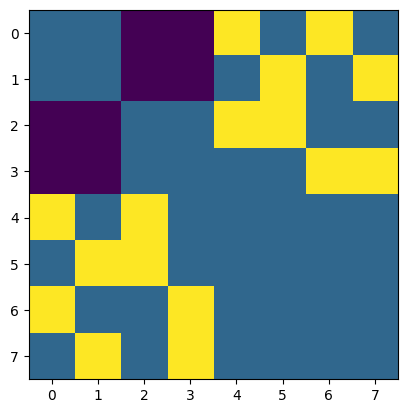

In [7]:
import matplotlib.pyplot as plt

plt.imshow(j_matrix)

In [20]:
import pulp

problem = pulp.LpProblem('AND',pulp.LpMinimize)

# Energy
E = pulp.LpVariable('E',-1000000,1000000,'Continuous')
# Biases
h = pulp.LpVariable.dicts('h',([0],[0,1,2,3]),-100,100,'Integer')
# Weights
j = pulp.LpVariable.dicts('j',([0],[0,1,2,3,4,5]),-100,100,'Integer')

# Dummy summation variables
H_h, H_j = (0,0)

# Iterate over rows of the above table
for i in range(16):
    # Generate correct values
    A,B,C,D = [2 * int(bit) - 1 for bit in format(i, f'0{4}b')]

    # Individual terms of final energy
    H_hp = A*h[0][0] + B*h[0][1] + C*h[0][2] + D*h[0][3]
    H_jp = A*B*j[0][0] + B*C*j[0][1] + A*C*j[0][2] + A*D*j[0][3] + B*D*j[0][4] + C*D*j[0][5]

    # Summed terms of final energy
    H_h = H_h + H_hp
    H_j = H_j + H_jp

    # Add energy constraints determined above
    if ((A > 0) or (B > 0) or (C > 0)) == (D > 0):
        print(i,A,B,C,D)
        problem += (-1)*H_hp-H_jp-E == 0
    else:
        problem += (-1)*H_hp-H_jp-E-1 >= 0

# Finally layout the objective function to minimize
problem += -H_h-H_j-E

# Checprint(j.,h.values())k that problem described is what was intended
problem.coefficients

0 -1 -1 -1 -1
3 -1 -1 1 1
5 -1 1 -1 1
7 -1 1 1 1
9 1 -1 -1 1
11 1 -1 1 1
13 1 1 -1 1
15 1 1 1 1


<bound method LpProblem.coefficients of AND:
MINIMIZE
-1*E + 0*h_0_0 + 0*h_0_1 + 0*h_0_2 + 0*h_0_3 + 0*j_0_0 + 0*j_0_1 + 0*j_0_2 + 0*j_0_3 + 0*j_0_4 + 0*j_0_5 + 0
SUBJECT TO
_C1: - E + h_0_0 + h_0_1 + h_0_2 + h_0_3 - j_0_0 - j_0_1 - j_0_2 - j_0_3
 - j_0_4 - j_0_5 = 0

_C2: - E + h_0_0 + h_0_1 + h_0_2 - h_0_3 - j_0_0 - j_0_1 - j_0_2 + j_0_3
 + j_0_4 + j_0_5 >= 1

_C3: - E + h_0_0 + h_0_1 - h_0_2 + h_0_3 - j_0_0 + j_0_1 + j_0_2 - j_0_3
 - j_0_4 + j_0_5 >= 1

_C4: - E + h_0_0 + h_0_1 - h_0_2 - h_0_3 - j_0_0 + j_0_1 + j_0_2 + j_0_3
 + j_0_4 - j_0_5 = 0

_C5: - E + h_0_0 - h_0_1 + h_0_2 + h_0_3 + j_0_0 + j_0_1 - j_0_2 - j_0_3
 + j_0_4 - j_0_5 >= 1

_C6: - E + h_0_0 - h_0_1 + h_0_2 - h_0_3 + j_0_0 + j_0_1 - j_0_2 + j_0_3
 - j_0_4 + j_0_5 = 0

_C7: - E + h_0_0 - h_0_1 - h_0_2 + h_0_3 + j_0_0 - j_0_1 + j_0_2 - j_0_3
 + j_0_4 + j_0_5 >= 1

_C8: - E + h_0_0 - h_0_1 - h_0_2 - h_0_3 + j_0_0 - j_0_1 + j_0_2 + j_0_3
 - j_0_4 - j_0_5 = 0

_C9: - E - h_0_0 + h_0_1 + h_0_2 + h_0_3 + j_0_0 - j_0_1 + j_0

In [21]:
problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/thomas/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4447b3f57b1f4092a72ea7ba1628ce30-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/4447b3f57b1f4092a72ea7ba1628ce30-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 229 RHS
At line 246 BOUNDS
At line 269 ENDATA
Problem MODEL has 16 rows, 11 columns and 176 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



-1

In [18]:
# Get final values of output
print("J_AB=",pulp.value(j[0][0]))
print("J_BC=",pulp.value(j[0][1]))
print("J_AC=",pulp.value(j[0][2]))
print("J_AD=",pulp.value(j[0][3]))
print("J_BD=",pulp.value(j[0][4]))
print("J_CD=",pulp.value(j[0][5]))
print("- "*5)
print("h_A=",pulp.value(h[0][0]))
print("h_B=",pulp.value(h[0][1]))
print("h_C=",pulp.value(h[0][2]))
print("h_D=",pulp.value(h[0][3]))

J_AB= -0.25
J_BC= -0.25
J_AC= 0.0
J_AD= 0.5
J_BD= 0.5
J_CD= 0.5
- - - - - 
h_A= -0.25
h_B= -0.5
h_C= -0.25
h_D= 1.0
